<a href="https://colab.research.google.com/github/dandan72/project/blob/main/Machine_Learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# חיזוי גיל ומגדר לפי תמונה 
### דניאל ניסים
### קישור למאגר הנתונים : [UTKFace - kaggle](https://www.kaggle.com/datasets/jangedoo/utkface-new)
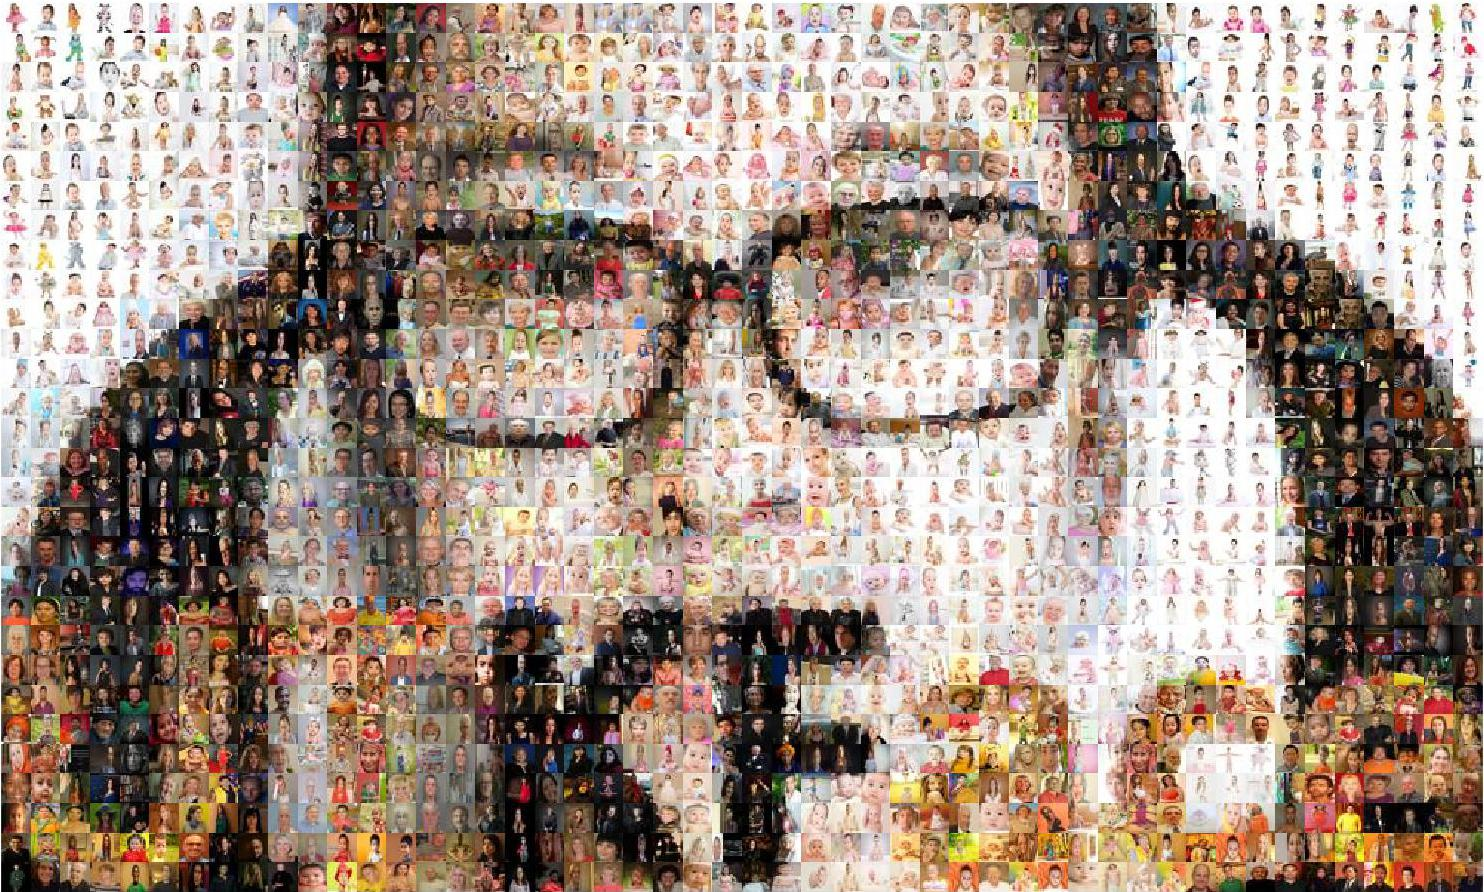
### קישור לסרטון המדגים את שלב היישום : [סרטון הדגמת יישום](https://drive.google.com/file/d/16zTqFVsUBwyTNx01bl6mYgi55ox5UU0M/view?usp=share_link)

In [ ]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
from tqdm import tqdm
from tensorflow.keras.utils import load_img
from tensorflow.keras import models, layers
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [ ]:
!pip install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 2.0 MB/s eta 0:00:00


In [ ]:
from keras_preprocessing.image import ImageDataGenerator

In [ ]:
import sklearn.metrics

In [ ]:
from sklearn.model_selection import train_test_split

## טעינת נתונים

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# הורדת מאגר הנתונים ושמירתו 
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Colab Notebooks/Data"
%cd /tmp/
!kaggle datasets download -d jangedoo/utkface-new
!unzip -qq -o utkface-new

/tmp
 99% 329M/331M [00:11<00:00, 33.7MB/s]
100% 331M/331M [00:11<00:00, 29.0MB/s]


In [ ]:
dir = '/tmp/UTKFace/'

In [ ]:
# חלוקת מאגר הנתונים לתמונות, גיל ומגדר
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(dir)):
  image_path = os.path.join(dir, filename)
  temp = filename.split('_')
  age = int(temp[0])
  gender = int(temp[1])
  image_paths.append(image_path)
  age_labels.append(age)
  gender_labels.append(gender)

100%|██████████| 23708/23708 [00:00<00:00, 365174.80it/s]


In [ ]:
# dataframe-הפיכת הרשימות ל
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels

<Axes: xlabel='age'>

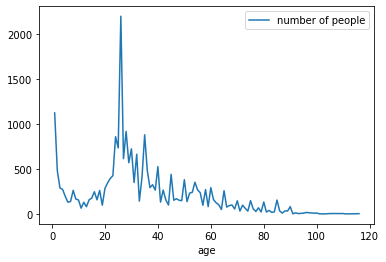

In [ ]:
# הצגת התפלגות גילאים
ages = df.groupby('age')
df_ages = ages.size().to_frame(name='number of people')
df_ages.plot()

<Axes: xlabel='gender', ylabel='count'>

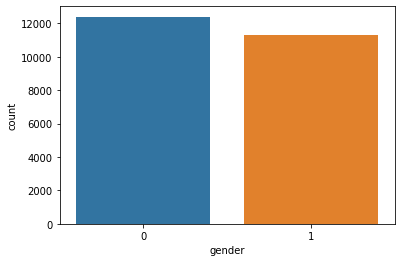

In [ ]:
# הצגת התפלגות מגדר
sns.countplot(x=df['gender'])

In [ ]:
# קביעת 0 ו-1 כגבר ואישה
gender_dict = {0:'Male', 1:'Female'}

In [ ]:
# הצגת מידע על מאגר הנתונים
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23708 entries, 0 to 23707
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   23708 non-null  object
 1   age     23708 non-null  int64 
 2   gender  23708 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 555.8+ KB


In [ ]:
# test-ו train-חלוקת מאגר הנתונים ל
df_train, test = train_test_split(df, test_size=0.2)

In [ ]:
test_labels_age = test['age']

In [ ]:
test_labels_gender = test['gender']

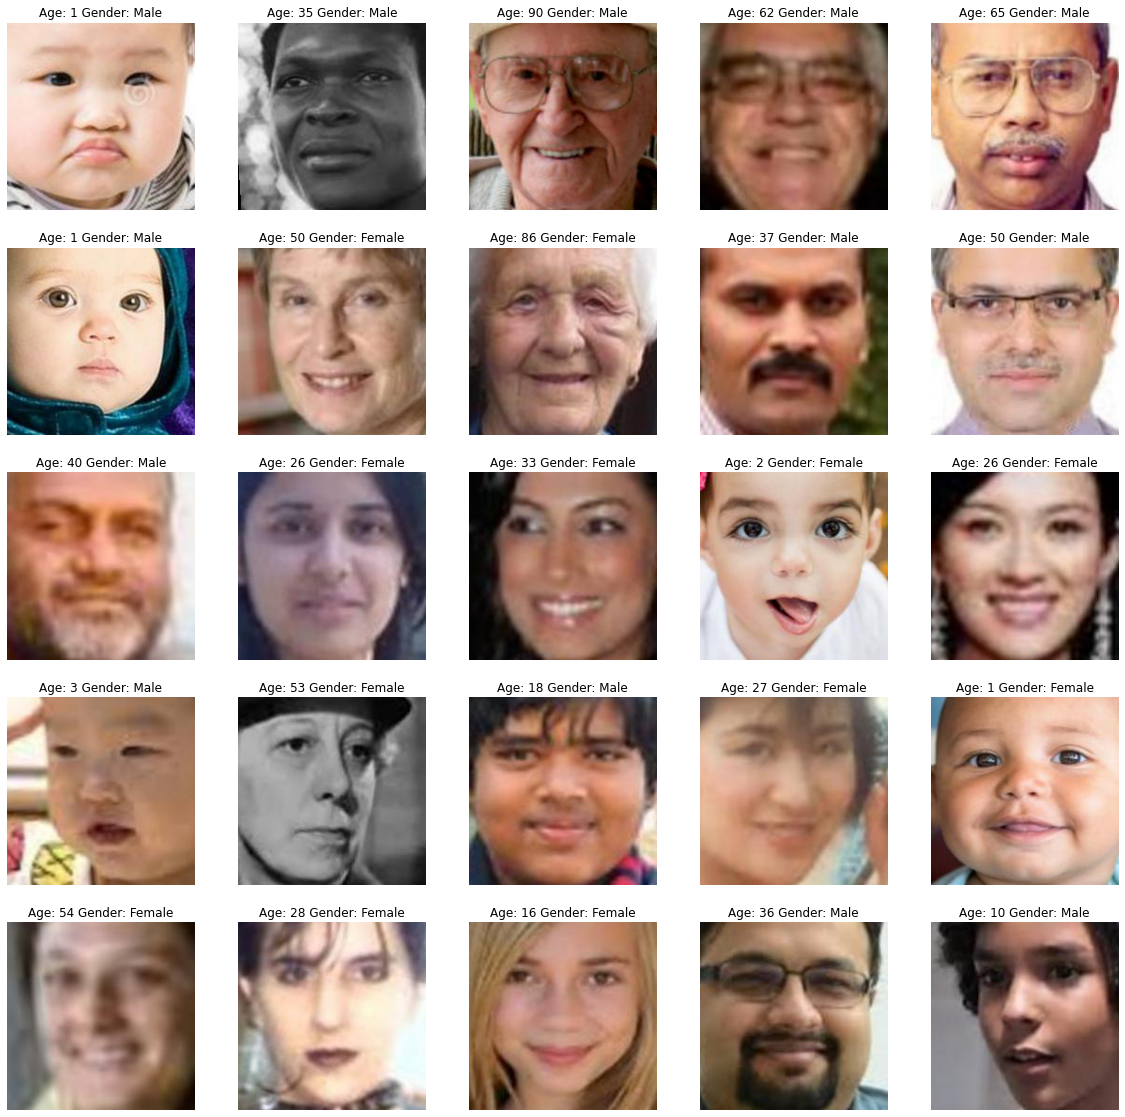

In [ ]:
# הצגת מספר תמונות ממאגר הנתונים והצגת הגיל והמגדר המתאים לכל תמונה
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

In [ ]:
# validation -ו test ,train-חלוקת מאגר הנתונים ל
dg = ImageDataGenerator(rescale=1/255, validation_split=0.2)

In [ ]:
train_age = dg.flow_from_dataframe(dataframe=df_train, x_col='image', y_col=['age'], subset="training", batch_size=64, target_size=(128, 128), class_mode='raw', shuffle=True)

Found 15173 validated image filenames.


In [ ]:
train_gender = dg.flow_from_dataframe(dataframe=df_train, x_col='image', y_col=['gender'], subset="training", batch_size=64, target_size=(128, 128), class_mode='raw', shuffle=True)

Found 15173 validated image filenames.


In [ ]:
val_age = dg.flow_from_dataframe(dataframe=df_train, x_col='image', y_col=['age'], subset="validation", batch_size=64, target_size=(128, 128), class_mode='raw', shuffle=False)

Found 3793 validated image filenames.


In [ ]:
val_gender = dg.flow_from_dataframe(dataframe=df_train, x_col='image', y_col=['gender'], subset="validation", batch_size=64, target_size=(128, 128), class_mode='raw', shuffle=False)

Found 3793 validated image filenames.


In [ ]:
test_dg = ImageDataGenerator(rescale=1/255)

In [ ]:
ds_test_age = test_dg.flow_from_dataframe(dataframe=test, x_col='image', y_col=['age'], batch_size=64, target_size=(128, 128), class_mode='raw', shuffle=False)

Found 4742 validated image filenames.


In [ ]:
ds_test_gender = test_dg.flow_from_dataframe(dataframe=test, x_col='image', y_col=['gender'], batch_size=64, target_size=(128, 128), class_mode='raw', shuffle=False)

Found 4742 validated image filenames.


In [ ]:
# פונקציה שעושה עיבוד לתמונה 
def extract_feature(image):
  img = load_img(image, grayscale=False)
  img = img.resize((128, 128))
  img = np.array(img)/255
  return img

In [ ]:
# פונקציה שמנבאת מגדר 0 או 1 לתמונה
def predict_gender(predictions):
  return (predictions >= 0.5)*1

## מודל בסיסי

In [ ]:
# בניית מודל בסיסי 
inputs = tf.keras.Input(shape=(128, 128, 3))

x1 = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(inputs)
x1 = layers.BatchNormalization()(x1)
x1 = layers.MaxPooling2D(pool_size=(3, 3))(x1)
x1 = layers.Conv2D(128, kernel_size=(3, 3), activation='relu')(x1)
x1 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x1)
x1 = layers.Conv2D(256, kernel_size=(3, 3), activation='relu')(x1)
x1 = layers.MaxPooling2D(pool_size=(2, 2))(x1)

x1 = layers.GlobalAveragePooling2D()(x1)

x1 = layers.Dense(256, activation='relu')(x1)
x1 = layers.Dense(256, activation='relu')(x1)
dense1 = layers.Dense(128, activation='relu')(x1)
dense2 = layers.Dense(128, activation='relu')(x1)
dropout1 = layers.Dropout(0.4)(dense1)
dropout2 = layers.Dropout(0.4)(dense2)

output1 = layers.Dense(1, activation='sigmoid', name='gender')(dropout1)
output2 = layers.Dense(1, activation='relu', name='age')(dropout2)

model1_age = tf.keras.Model(inputs=[inputs], outputs=[output2]) 

model1_age.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 42, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0     

In [ ]:
model1_gender = tf.keras.Model(inputs=[inputs], outputs=[output1]) 
model1_gender.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 42, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0   

In [ ]:
# קריאה שעוצרת את תהליך האימון ברגע שאין שיפור בלמידה
my_callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

### חיזוי גיל

In [ ]:
# הכנת המודל לאימון 
base_learning_rate = 0.01
model1_age.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss={'age':'mae'},    
              metrics={'age':'mae'})  

In [ ]:
# אימון המודל
history_age = model1_age.fit(train_age,
                     epochs=70,
                     validation_data=val_age, 
                     callbacks=[my_callback_es]) 


val_mae_list = history_age.history['val_mae']
min_val_mae = min(val_mae_list)
argmax_val_mae = np.argmax(val_mae_list)
print(f"The minimum val_mae was {format(min_val_mae, '.2f')} and it was reached on epoch {argmax_val_mae+1} out of {len(val_mae_list)}")

val_loss_list = history_age.history['val_loss']
min_val_loss = min(val_loss_list)
argmax_val_loss = np.argmax(val_loss_list)
print(f"The minimum val_loss was {format(min_val_loss, '.2f')} and it was reached on epoch {argmax_val_loss+1} out of {len(val_loss_list)}")

Epoch 1/70
238/238 [==============================] - 42s 118ms/step - loss: 17.3126 - mae: 17.3126 - val_loss: 16.5307 - val_mae: 16.5307
Epoch 2/70
238/238 [==============================] - 28s 116ms/step - loss: 15.2152 - mae: 15.2152 - val_loss: 14.5100 - val_mae: 14.5100
Epoch 3/70
238/238 [==============================] - 28s 116ms/step - loss: 14.4225 - mae: 14.4225 - val_loss: 15.1647 - val_mae: 15.1647
Epoch 4/70
238/238 [==============================] - 27s 114ms/step - loss: 13.3844 - mae: 13.3844 - val_loss: 13.9320 - val_mae: 13.9320
Epoch 5/70
238/238 [==============================] - 28s 116ms/step - loss: 12.6546 - mae: 12.6546 - val_loss: 14.6084 - val_mae: 14.6084
Epoch 6/70
238/238 [==============================] - 28s 115ms/step - loss: 11.8777 - mae: 11.8777 - val_loss: 13.9649 - val_mae: 13.9649
Epoch 7/70
238/238 [==============================] - 27s 115ms/step - loss: 11.6090 - mae: 11.6090 - val_loss: 21.5565 - val_mae: 21.5565
Epoch 8/70
238/238 [=======

In [ ]:
# שמירת המודל
model1_age.save("/content/drive/MyDrive/Colab Notebooks/Data/models/model1_age")

In [ ]:
# שמירת נתוני אימון 
mae = history_age.history['mae']
val_mae = history_age.history['val_mae']
loss = history_age.history['loss']
val_loss = history_age.history['val_loss']

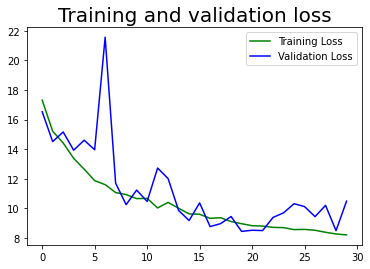

In [ ]:
# הצגת נתוני אימון בגרפים
plt.figure()
plt.plot(loss, 'g', label='Training Loss')
plt.plot(val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss', fontsize=20)
plt.legend();

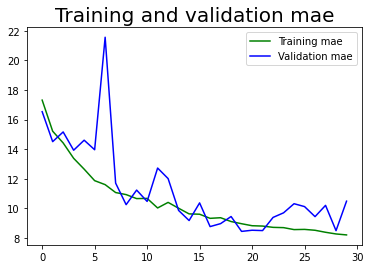

In [ ]:
plt.plot(mae, 'g', label='Training mae')
plt.plot(val_mae, 'b', label='Validation mae')
plt.title('Training and validation mae', fontsize=20)
plt.legend();

In [ ]:
# test-חיזוי נתונים מ
pred_age = model1_age.predict(ds_test_age)

75/75 [==============================] - 6s 75ms/step


In [ ]:
# הערכת ביצועים 
sklearn.metrics.r2_score(test_labels_age, pred_age)

0.6496552924989085

In [ ]:
image_60 = extract_feature(df['image'][60])

Original Age: 40
1/1 [==============================] - 0s 41ms/step
Predicted Age: [[0.]]


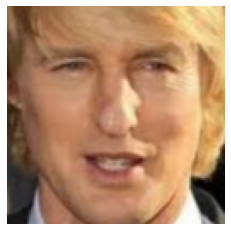

In [ ]:
# הצגת ויזואלית של פרדיקציות 
print("Original Age:", df['age'][60])
predage_60 = np.round(model1_age.predict(image_60.reshape(1, 128, 128, 3)))
print("Predicted Age:", predage_60)
plt.axis('off')
plt.imshow(image_60);

### חיזוי מגדר

In [ ]:
# הכנת המודל לאימון
base_learning_rate = 0.01
model1_gender.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss={'gender':'binary_crossentropy'}, 
              metrics={'gender':'accuracy'}) 

In [ ]:
# אימון המודל 
history_gender = model1_gender.fit(train_gender,
                     epochs=70,
                     validation_data=val_gender, 
                     callbacks=[my_callback_es]) 


val_acc_list = history_gender.history['val_accuracy']
min_val_acc = max(val_acc_list)
argmax_val_acc = np.argmax(val_acc_list)
print(f"The maximum val_accuracy was {format(min_val_acc, '.2f')} and it was reached on epoch {argmax_val_acc+1} out of {len(val_acc_list)}")

val_loss_list = history_gender.history['val_loss']
min_val_loss = min(val_loss_list)
argmax_val_loss = np.argmax(val_loss_list)
print(f"The minimum val_loss was {format(min_val_loss, '.2f')} and it was reached on epoch {argmax_val_loss+1} out of {len(val_loss_list)}")

Epoch 1/70
238/238 [==============================] - 31s 114ms/step - loss: 0.5717 - accuracy: 0.7109 - val_loss: 0.6600 - val_accuracy: 0.5761
Epoch 2/70
238/238 [==============================] - 28s 118ms/step - loss: 0.4865 - accuracy: 0.7820 - val_loss: 0.4800 - val_accuracy: 0.7717
Epoch 3/70
238/238 [==============================] - 27s 114ms/step - loss: 0.4560 - accuracy: 0.7974 - val_loss: 0.4848 - val_accuracy: 0.7722
Epoch 4/70
238/238 [==============================] - 27s 111ms/step - loss: 0.4315 - accuracy: 0.8102 - val_loss: 0.5540 - val_accuracy: 0.7224
Epoch 5/70
238/238 [==============================] - 28s 115ms/step - loss: 0.4222 - accuracy: 0.8115 - val_loss: 0.4342 - val_accuracy: 0.8057
Epoch 6/70
238/238 [==============================] - 26s 110ms/step - loss: 0.3996 - accuracy: 0.8245 - val_loss: 0.4392 - val_accuracy: 0.8065
Epoch 7/70
238/238 [==============================] - 27s 113ms/step - loss: 0.3938 - accuracy: 0.8257 - val_loss: 0.4636 - val_ac

In [ ]:
# שמירת המודל
model1_gender.save("/content/drive/MyDrive/Colab Notebooks/Data/models/model1_gender")

In [ ]:
# שמירת נתוני אימון 
acc = history_gender.history['accuracy']
val_acc = history_gender.history['val_accuracy']
loss = history_gender.history['loss']
val_loss = history_gender.history['val_loss']

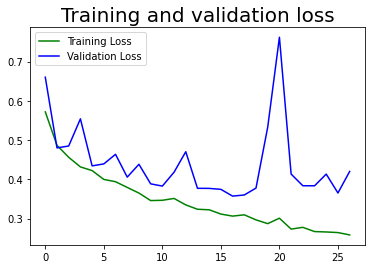

In [ ]:
# הצגת נתוני אימון בגרפים
plt.figure()
plt.plot(loss, 'g', label='Training Loss')
plt.plot(val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss', fontsize=20)
plt.legend();

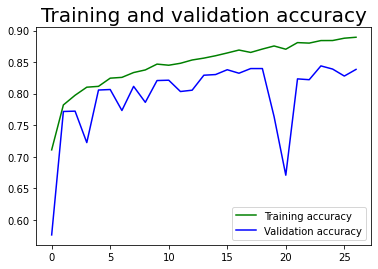

In [ ]:
plt.plot(acc, 'g', label='Training accuracy')
plt.plot(val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy', fontsize=20)
plt.legend();

In [ ]:
# test-חיזוי נתונים מ
pred_gender = predict_gender(model1_gender.predict(ds_test_gender))

75/75 [==============================] - 6s 84ms/step


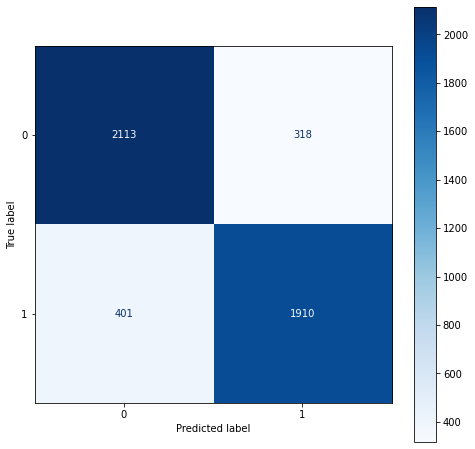

In [ ]:
# הערכת ביצועים
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(y_true=test_labels_gender, y_pred=pred_gender,cmap=plt.cm.Blues, ax=ax);

In [ ]:
print(classification_report(y_true=test_labels_gender,y_pred=pred_gender,digits=4))

              precision    recall  f1-score   support

           0     0.8405    0.8692    0.8546      2431
           1     0.8573    0.8265    0.8416      2311

    accuracy                         0.8484      4742
   macro avg     0.8489    0.8478    0.8481      4742
weighted avg     0.8487    0.8484    0.8483      4742



In [ ]:
image_60 = extract_feature(df['image'][60])

Original Gender: Male
1/1 [==============================] - 1s 665ms/step
Predicted Gender:  Female


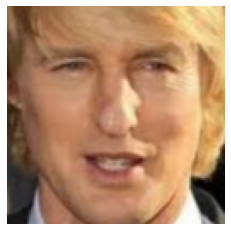

In [ ]:
# הצגה ויזואלית של פרדיקציות
print("Original Gender:", gender_dict[df['gender'][60]])
predgender_60 = predict_gender(model1_gender.predict(image_60.reshape(1, 128, 128, 3)))
print("Predicted Gender: ", gender_dict[predgender_60[0][0]])
plt.axis('off')
plt.imshow(image_60);

## מודל 2

In [ ]:
# בניית מודל
inputs = tf.keras.Input(shape=(128, 128, 3))

x2 = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(inputs)
x2 = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x2)
x2 = layers.BatchNormalization()(x2)
x2 = layers.MaxPooling2D(pool_size=(3, 3))(x2)
x2 = layers.Conv2D(128, kernel_size=(3, 3), activation='relu')(x2)
x2 = layers.Conv2D(128, kernel_size=(3, 3), activation='relu')(x2)
x2 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x2)
x2 = layers.Conv2D(256, kernel_size=(3, 3), activation='relu')(x2)
x2 = layers.Conv2D(256, kernel_size=(3, 3), activation='relu')(x2)
x2 = layers.MaxPooling2D(pool_size=(2, 2))(x2)

x2 = layers.GlobalAveragePooling2D()(x2)

x2 = layers.Dense(256, activation='relu')(x2)
dense1 = layers.Dense(128, activation='relu')(x2)
dense2 = layers.Dense(128, activation='relu')(x2)
dropout1 = layers.Dropout(0.3)(dense1)
dropout2 = layers.Dropout(0.3)(dense2)

output1 = layers.Dense(1, activation='sigmoid', name='gender')(dropout1)
output2 = layers.Dense(1, activation='relu', name='age')(dropout2)

model2_age = tf.keras.Model(inputs=[inputs], outputs=[output2]) 

model2_age.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 126, 126, 64)      1792      
                                                                 
 conv2d_4 (Conv2D)           (None, 124, 124, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 124, 124, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 41, 41, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 39, 39, 128)       7385

In [ ]:
model2_gender = tf.keras.Model(inputs=[inputs], outputs=[output1]) 
model2_gender.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 126, 126, 64)      1792      
                                                                 
 conv2d_4 (Conv2D)           (None, 124, 124, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 124, 124, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 41, 41, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 39, 39, 128)       7385

In [ ]:
# קריאה שעוצרת את תהליך האימון ברגע שאין שיפור בלמידה
my_callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

### חיזוי גיל

In [ ]:
# הכנת המודל לאימון 
base_learning_rate = 0.001
model2_age.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss={'age':'mae'},    
              metrics={'age':'mae'})  

In [ ]:
# אימון המודל 
history2_age = model2_age.fit(train_age,
                     epochs=70,
                     validation_data=val_age, 
                     callbacks=[my_callback_es]) 


val_mae_list = history2_age.history['val_mae']
min_val_mae = min(val_mae_list)
argmax_val_mae = np.argmax(val_mae_list)
print(f"The minimum val_mae was {format(min_val_mae, '.2f')} and it was reached on epoch {argmax_val_mae+1} out of {len(val_mae_list)}")

val_loss_list = history2_age.history['val_loss']
min_val_loss = min(val_loss_list)
argmax_val_loss = np.argmax(val_loss_list)
print(f"The minimum val_loss was {format(min_val_loss, '.2f')} and it was reached on epoch {argmax_val_loss+1} out of {len(val_loss_list)}")

Epoch 1/70
238/238 [==============================] - 46s 175ms/step - loss: 15.2686 - mae: 15.2686 - val_loss: 28.5797 - val_mae: 28.5797
Epoch 2/70
238/238 [==============================] - 35s 146ms/step - loss: 13.6266 - mae: 13.6266 - val_loss: 20.1753 - val_mae: 20.1753
Epoch 3/70
238/238 [==============================] - 36s 151ms/step - loss: 12.2602 - mae: 12.2602 - val_loss: 12.1647 - val_mae: 12.1647
Epoch 4/70
238/238 [==============================] - 35s 147ms/step - loss: 10.7369 - mae: 10.7369 - val_loss: 13.4372 - val_mae: 13.4372
Epoch 5/70
238/238 [==============================] - 35s 146ms/step - loss: 10.1850 - mae: 10.1850 - val_loss: 9.7164 - val_mae: 9.7164
Epoch 6/70
238/238 [==============================] - 35s 147ms/step - loss: 9.3468 - mae: 9.3468 - val_loss: 14.4848 - val_mae: 14.4848
Epoch 7/70
238/238 [==============================] - 35s 145ms/step - loss: 8.9492 - mae: 8.9492 - val_loss: 9.3071 - val_mae: 9.3071
Epoch 8/70
238/238 [===============

In [ ]:
# שמירת המודל
model2_age.save("/content/drive/MyDrive/Colab Notebooks/Data/models/model2_age")

In [ ]:
# שמירת נתוני אימון 
mae = history2_age.history['mae']
val_mae = history2_age.history['val_mae']
loss = history2_age.history['loss']
val_loss = history2_age.history['val_loss']

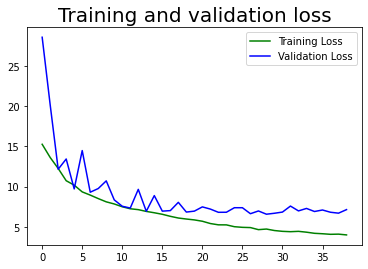

In [ ]:
# הצגת נתוני אימון בגרפים
plt.figure()
plt.plot(loss, 'g', label='Training Loss')
plt.plot(val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss', fontsize=20)
plt.legend();

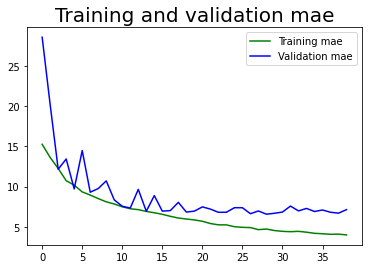

In [ ]:
plt.plot(mae, 'g', label='Training mae')
plt.plot(val_mae, 'b', label='Validation mae')
plt.title('Training and validation mae', fontsize=20)
plt.legend();

In [ ]:
# test-חיזוי נתונים מ
pred_age = model2_age.predict(ds_test_age)

75/75 [==============================] - 6s 85ms/step


In [ ]:
# הערכת ביצועים
sklearn.metrics.r2_score(test_labels_age, pred_age)

0.7860296028557809

In [ ]:
image_2 = extract_feature(df['image'][2])

Original Age: 45
1/1 [==============================] - 0s 269ms/step
Predicted Age: [[49.]]


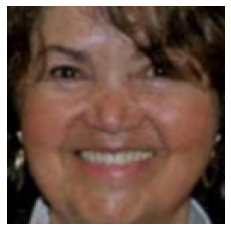

In [ ]:
# הצגת ויזואלית של פרדיקציות
print("Original Age:", df['age'][2])
predage_2 = np.round(model2_age.predict(image_2.reshape(1, 128, 128, 3)))
print("Predicted Age:", predage_2)
plt.axis('off')
plt.imshow(image_2);

### חיזוי מגדר

In [ ]:
# הכנת המודל לאימון
base_learning_rate = 0.001
model2_gender.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss={'gender':'binary_crossentropy'}, 
              metrics={'gender':'accuracy'}) 

In [ ]:
# אימון המודל
history2_gender = model2_gender.fit(train_gender,
                     epochs=70,
                     validation_data=val_gender, 
                     callbacks=[my_callback_es]) 


val_acc_list = history2_gender.history['val_accuracy']
min_val_acc = max(val_acc_list)
argmax_val_acc = np.argmax(val_acc_list)
print(f"The maximum val_accuracy was {format(min_val_acc, '.2f')} and it was reached on epoch {argmax_val_acc+1} out of {len(val_acc_list)}")

val_loss_list = history2_gender.history['val_loss']
min_val_loss = min(val_loss_list)
argmax_val_loss = np.argmax(val_loss_list)
print(f"The minimum val_loss was {format(min_val_loss, '.2f')} and it was reached on epoch {argmax_val_loss+1} out of {len(val_loss_list)}")

Epoch 1/70
238/238 [==============================] - 43s 171ms/step - loss: 0.4192 - accuracy: 0.8045 - val_loss: 0.4104 - val_accuracy: 0.8094
Epoch 2/70
238/238 [==============================] - 35s 146ms/step - loss: 0.2845 - accuracy: 0.8716 - val_loss: 0.3649 - val_accuracy: 0.8400
Epoch 3/70
238/238 [==============================] - 35s 145ms/step - loss: 0.2287 - accuracy: 0.9008 - val_loss: 0.3246 - val_accuracy: 0.8582
Epoch 4/70
238/238 [==============================] - 35s 147ms/step - loss: 0.1828 - accuracy: 0.9214 - val_loss: 0.5014 - val_accuracy: 0.7893
Epoch 5/70
238/238 [==============================] - 35s 147ms/step - loss: 0.1521 - accuracy: 0.9370 - val_loss: 0.3603 - val_accuracy: 0.8400
Epoch 6/70
238/238 [==============================] - 35s 148ms/step - loss: 0.1332 - accuracy: 0.9448 - val_loss: 0.4234 - val_accuracy: 0.8690
Epoch 7/70
238/238 [==============================] - 35s 147ms/step - loss: 0.1018 - accuracy: 0.9578 - val_loss: 0.4254 - val_ac

In [ ]:
# שמירת המודל
model2_gender.save("/content/drive/MyDrive/Colab Notebooks/Data/models/model2_gender")

In [ ]:
# שמירת נתוני אימון
acc = history2_gender.history['accuracy']
val_acc = history2_gender.history['val_accuracy']
loss = history2_gender.history['loss']
val_loss = history2_gender.history['val_loss']

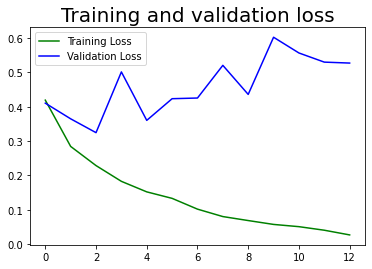

In [ ]:
# הצגת נתוני אימון בגרפים
plt.figure()
plt.plot(loss, 'g', label='Training Loss')
plt.plot(val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss', fontsize=20)
plt.legend();

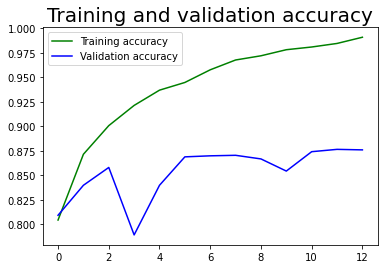

In [ ]:
plt.plot(acc, 'g', label='Training accuracy')
plt.plot(val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy', fontsize=20)
plt.legend();

In [ ]:
# test-חיזוי נתונים מ
pred_gender = predict_gender(model2_gender.predict(ds_test_gender))

75/75 [==============================] - 7s 96ms/step


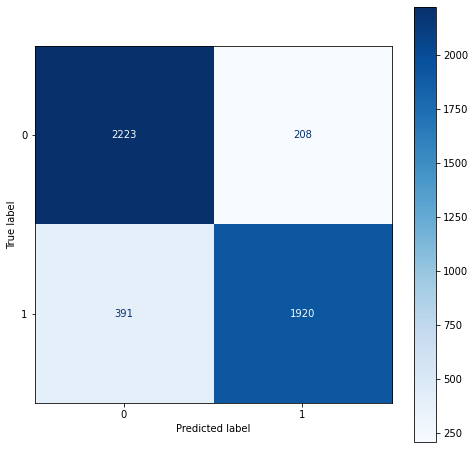

In [ ]:
# הערכת ביצועים
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(y_true=test_labels_gender, y_pred=pred_gender,cmap=plt.cm.Blues, ax=ax);

In [ ]:
print(classification_report(y_true=test_labels_gender,y_pred=pred_gender,digits=4))

              precision    recall  f1-score   support

           0     0.8504    0.9144    0.8813      2431
           1     0.9023    0.8308    0.8651      2311

    accuracy                         0.8737      4742
   macro avg     0.8763    0.8726    0.8732      4742
weighted avg     0.8757    0.8737    0.8734      4742



In [ ]:
image_2 = extract_feature(df['image'][2])

Original Gender: Female
1/1 [==============================] - 0s 100ms/step
Predicted Gender: Female


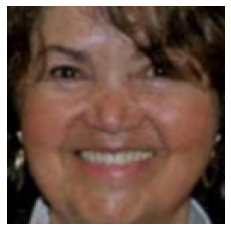

In [ ]:
# הצגה ויזואלית של פרדיקציות
print("Original Gender:", gender_dict[df['gender'][2]])
predgender_2 = predict_gender(model2_gender.predict(image_2.reshape(1, 128, 128, 3)))
print("Predicted Gender:", gender_dict[predgender_2[0][0]])
plt.axis('off')
plt.imshow(image_2);

## מודל 3

In [ ]:
# בניית מודל
inputs = tf.keras.Input(shape=(128, 128, 3))

x3 = layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
x3 = layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(x3)
x3 = layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(x3)
x3 = layers.BatchNormalization()(x3)
x3 = layers.MaxPooling2D(pool_size=(3, 3))(x3)
x3 = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x3)
x3 = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x3)
x3 = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x3)
x3 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x3)
x3 = layers.Conv2D(128, kernel_size=(3, 3), activation='relu')(x3)
x3 = layers.Conv2D(128, kernel_size=(3, 3), activation='relu')(x3)
x3 = layers.Conv2D(128, kernel_size=(3, 3), activation='relu')(x3)
x3 = layers.MaxPooling2D(pool_size=(2, 2))(x3)

x3 = layers.GlobalAveragePooling2D()(x3)

x3 = layers.Dense(256, activation='relu')(x3)
dense1 = layers.Dense(128, activation='relu')(x3)
dense2 = layers.Dense(128, activation='relu')(x3)
dropout1 = layers.Dropout(0.4)(dense1)
dropout2 = layers.Dropout(0.4)(dense2)

output1 = layers.Dense(1, activation='sigmoid', name='gender')(dropout1)
output2 = layers.Dense(1, activation='relu', name='age')(dropout2)

model3_age = tf.keras.Model(inputs=[inputs], outputs=[output2]) 

model3_age.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 conv2d_10 (Conv2D)          (None, 124, 124, 32)      9248      
                                                                 
 conv2d_11 (Conv2D)          (None, 122, 122, 32)      9248      
                                                                 
 batch_normalization_2 (Batc  (None, 122, 122, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 40, 40, 32)       0         
 2D)                                                       

In [ ]:
model3_gender = tf.keras.Model(inputs=[inputs], outputs=[output1]) 
model3_gender.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 conv2d_10 (Conv2D)          (None, 124, 124, 32)      9248      
                                                                 
 conv2d_11 (Conv2D)          (None, 122, 122, 32)      9248      
                                                                 
 batch_normalization_2 (Batc  (None, 122, 122, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 40, 40, 32)       0         
 2D)                                                       

In [ ]:
# קריאה שעוצרת את תהליך האימון ברגע שאין שיפור בלמידה
my_callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

### חיזוי גיל

In [ ]:
# הכנת המודל לאימון 
base_learning_rate = 0.001
model3_age.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss={'age':'mae'},    
              metrics={'age':'mae'})

In [ ]:
# אימון המודל
history3_age = model3_age.fit(train_age,
                     epochs=70,
                     validation_data=val_age, 
                     callbacks=[my_callback_es]) 


val_mae_list = history3_age.history['val_mae']
min_val_mae = min(val_mae_list)
argmax_val_mae = np.argmax(val_mae_list)
print(f"The minimum val_mae was {format(min_val_mae, '.2f')} and it was reached on epoch {argmax_val_mae+1} out of {len(val_mae_list)}")

val_loss_list = history3_age.history['val_loss']
min_val_loss = min(val_loss_list)
argmax_val_loss = np.argmax(val_loss_list)
print(f"The minimum val_loss was {format(min_val_loss, '.2f')} and it was reached on epoch {argmax_val_loss+1} out of {len(val_loss_list)}")

Epoch 1/70
238/238 [==============================] - 35s 126ms/step - loss: 15.3280 - mae: 15.3280 - val_loss: 26.2689 - val_mae: 26.2689
Epoch 2/70
238/238 [==============================] - 30s 126ms/step - loss: 13.2756 - mae: 13.2756 - val_loss: 20.5766 - val_mae: 20.5766
Epoch 3/70
238/238 [==============================] - 29s 123ms/step - loss: 11.9157 - mae: 11.9157 - val_loss: 11.7803 - val_mae: 11.7803
Epoch 4/70
238/238 [==============================] - 30s 126ms/step - loss: 10.6385 - mae: 10.6385 - val_loss: 9.9518 - val_mae: 9.9518
Epoch 5/70
238/238 [==============================] - 30s 125ms/step - loss: 9.5823 - mae: 9.5823 - val_loss: 8.8170 - val_mae: 8.8170
Epoch 6/70
238/238 [==============================] - 30s 124ms/step - loss: 9.3592 - mae: 9.3592 - val_loss: 9.4661 - val_mae: 9.4661
Epoch 7/70
238/238 [==============================] - 30s 124ms/step - loss: 8.8849 - mae: 8.8849 - val_loss: 8.7828 - val_mae: 8.7828
Epoch 8/70
238/238 [=====================

In [ ]:
# שמירת המודל
model3_age.save("/content/drive/MyDrive/Colab Notebooks/Data/models/model3_age")

In [ ]:
# שמירת נתוני אימון
mae = history3_age.history['mae']
val_mae = history3_age.history['val_mae']
loss = history3_age.history['loss']
val_loss = history3_age.history['val_loss']

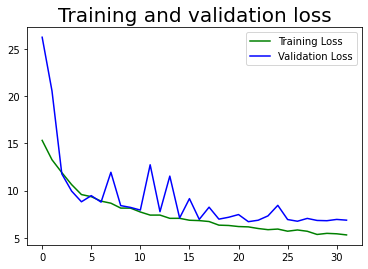

In [ ]:
# הצגת נתוני אימון בגרפים
plt.figure()
plt.plot(loss, 'g', label='Training Loss')
plt.plot(val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss', fontsize=20)
plt.legend();

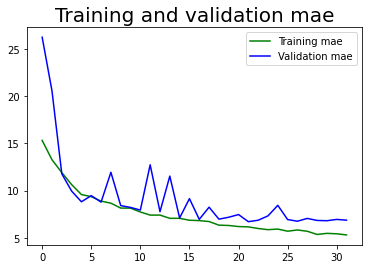

In [ ]:
plt.plot(mae, 'g', label='Training mae')
plt.plot(val_mae, 'b', label='Validation mae')
plt.title('Training and validation mae', fontsize=20)
plt.legend();

In [ ]:
# test-חיזי נתונים מ
pred_age = model3_age.predict(ds_test_age)

75/75 [==============================] - 7s 92ms/step


In [ ]:
# הערכת ביצועים
sklearn.metrics.r2_score(test_labels_age, pred_age)

0.7683931277592105

In [ ]:
image_15 = extract_feature(df['image'][15])

Original Age: 34
1/1 [==============================] - 0s 249ms/step
Predicted Age: [[35.]]


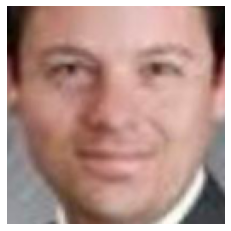

In [ ]:
# הצגה ויזואלית של פרדיקציות
print("Original Age:", df['age'][15])
predage_15 = np.round(model3_age.predict(image_15.reshape(1, 128, 128, 3)))
print("Predicted Age:", predage_15)
plt.axis('off')
plt.imshow(image_15);

### חיזוי מגדר

In [ ]:
# הכנת המודל לאימון
base_learning_rate = 0.001
model3_gender.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss={'gender':'binary_crossentropy'}, 
              metrics={'gender':'accuracy'}) 

In [ ]:
# אימון המודל
history3_gender = model3_gender.fit(train_gender,
                     epochs=70,
                     validation_data=val_gender, 
                     callbacks=[my_callback_es]) 


val_acc_list = history3_gender.history['val_accuracy']
min_val_acc = max(val_acc_list)
argmax_val_acc = np.argmax(val_acc_list)
print(f"The maximum val_accuracy was {format(min_val_acc, '.2f')} and it was reached on epoch {argmax_val_acc+1} out of {len(val_acc_list)}")

val_loss_list = history3_gender.history['val_loss']
min_val_loss = min(val_loss_list)
argmax_val_loss = np.argmax(val_loss_list)
print(f"The minimum val_loss was {format(min_val_loss, '.2f')} and it was reached on epoch {argmax_val_loss+1} out of {len(val_loss_list)}")

Epoch 1/70
238/238 [==============================] - 33s 123ms/step - loss: 0.4027 - accuracy: 0.8100 - val_loss: 0.4069 - val_accuracy: 0.8102
Epoch 2/70
238/238 [==============================] - 30s 126ms/step - loss: 0.2928 - accuracy: 0.8736 - val_loss: 0.3883 - val_accuracy: 0.8429
Epoch 3/70
238/238 [==============================] - 30s 124ms/step - loss: 0.2539 - accuracy: 0.8897 - val_loss: 0.3141 - val_accuracy: 0.8608
Epoch 4/70
238/238 [==============================] - 35s 146ms/step - loss: 0.2244 - accuracy: 0.9032 - val_loss: 0.3015 - val_accuracy: 0.8684
Epoch 5/70
238/238 [==============================] - 29s 122ms/step - loss: 0.1948 - accuracy: 0.9186 - val_loss: 0.3114 - val_accuracy: 0.8682
Epoch 6/70
238/238 [==============================] - 29s 123ms/step - loss: 0.2011 - accuracy: 0.9155 - val_loss: 0.2978 - val_accuracy: 0.8761
Epoch 7/70
238/238 [==============================] - 29s 122ms/step - loss: 0.1692 - accuracy: 0.9305 - val_loss: 0.3482 - val_ac

In [ ]:
# שמירת המודל
model3_gender.save("/content/drive/MyDrive/Colab Notebooks/Data/models/model3_gender")

In [ ]:
# שמירת נתוני אימון
acc = history3_gender.history['accuracy']
val_acc = history3_gender.history['val_accuracy']
loss = history3_gender.history['loss']
val_loss = history3_gender.history['val_loss']

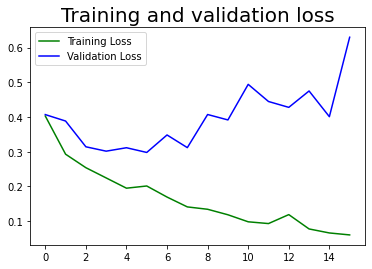

In [ ]:
# הצגת נתוני אימון בגרפים
plt.figure()
plt.plot(loss, 'g', label='Training Loss')
plt.plot(val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss', fontsize=20)
plt.legend();

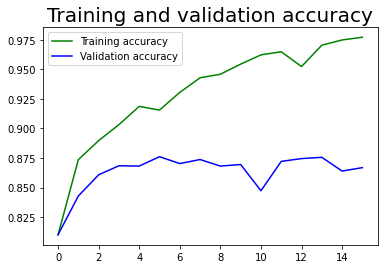

In [ ]:
plt.plot(acc, 'g', label='Training accuracy')
plt.plot(val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy', fontsize=20)
plt.legend();

In [ ]:
# test-חיזוי נתונים מ
pred_gender = predict_gender(model3_gender.predict(ds_test_gender))

75/75 [==============================] - 7s 95ms/step


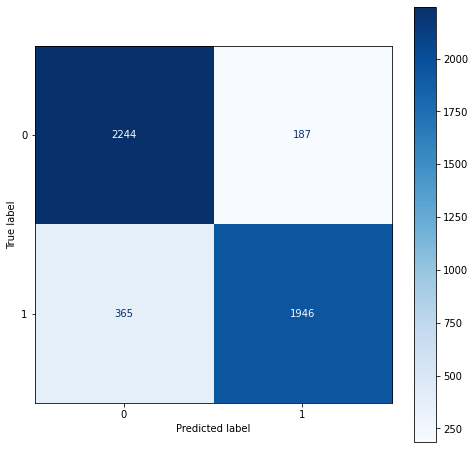

In [ ]:
# הערכת ביצועים
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(y_true=test_labels_gender, y_pred=pred_gender,cmap=plt.cm.Blues, ax=ax);

In [ ]:
print(classification_report(y_true=test_labels_gender,y_pred=pred_gender,digits=4))

              precision    recall  f1-score   support

           0     0.8601    0.9231    0.8905      2431
           1     0.9123    0.8421    0.8758      2311

    accuracy                         0.8836      4742
   macro avg     0.8862    0.8826    0.8831      4742
weighted avg     0.8856    0.8836    0.8833      4742



In [ ]:
image_15 = extract_feature(df['image'][15])

Original Gender: Male
1/1 [==============================] - 0s 117ms/step
Predicted Gender: Male


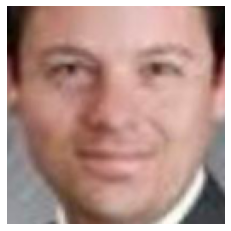

In [ ]:
# הצגה ויזואלית של פרדיקציות
print("Original Gender:", gender_dict[df['gender'][15]])
predgender_15 = predict_gender(model3_gender.predict(image_15.reshape(1, 128, 128, 3)))
print("Predicted Gender:", gender_dict[predgender_15[0][0]])
plt.axis('off')
plt.imshow(image_15);

## מודל 4

In [ ]:
# בניית מודל
inputs = tf.keras.Input(shape=(128, 128, 3))

x4 = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(inputs)
x4 = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x4)
x4 = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x4)
x4 = layers.BatchNormalization()(x4)
x4 = layers.MaxPooling2D(pool_size=(3, 3))(x4)
x4 = layers.Conv2D(128, kernel_size=(3, 3), activation='relu')(x4)
x4 = layers.Conv2D(128, kernel_size=(3, 3), activation='relu')(x4)
x4 = layers.Conv2D(128, kernel_size=(3, 3), activation='relu')(x4)
x4 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x4)
x4 = layers.Conv2D(256, kernel_size=(3, 3), activation='relu')(x4)
x4 = layers.Conv2D(256, kernel_size=(3, 3), activation='relu')(x4)
x4 = layers.Conv2D(256, kernel_size=(3, 3), activation='relu')(x4)
x4 = layers.MaxPooling2D(pool_size=(2, 2))(x4)

x4 = layers.GlobalAveragePooling2D()(x4)

x4 = layers.Dense(128, activation='relu')(x4)
dense1 = layers.Dense(128, activation='relu')(x4)
dense2 = layers.Dense(128, activation='relu')(x4)
dropout1 = layers.Dropout(0.4)(dense1)
dropout2 = layers.Dropout(0.4)(dense2)

output1 = layers.Dense(1, activation='sigmoid', name='gender')(dropout1)
output2 = layers.Dense(1, activation='relu', name='age')(dropout2)

model4_age = tf.keras.Model(inputs=[inputs], outputs=[output2]) 

model4_age.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_18 (Conv2D)          (None, 126, 126, 64)      1792      
                                                                 
 conv2d_19 (Conv2D)          (None, 124, 124, 64)      36928     
                                                                 
 conv2d_20 (Conv2D)          (None, 122, 122, 64)      36928     
                                                                 
 batch_normalization_3 (Batc  (None, 122, 122, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 40, 40, 64)       0         
 2D)                                                       

In [ ]:
model4_gender = tf.keras.Model(inputs=[inputs], outputs=[output1]) 
model4_gender.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_18 (Conv2D)          (None, 126, 126, 64)      1792      
                                                                 
 conv2d_19 (Conv2D)          (None, 124, 124, 64)      36928     
                                                                 
 conv2d_20 (Conv2D)          (None, 122, 122, 64)      36928     
                                                                 
 batch_normalization_3 (Batc  (None, 122, 122, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 40, 40, 64)       0         
 2D)                                                       

In [ ]:
# קריאה שעוצרת את תהליך האימון ברגע שאין שיפור בלמידה
my_callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

### חיזוי גיל

In [ ]:
# הכנת המודל לאימון
base_learning_rate = 0.001
model4_age.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss={'age':'mae'},    
              metrics={'age':'mae'}) 

In [ ]:
# אימון המודל
history4_age = model4_age.fit(train_age,
                     epochs=70,
                     validation_data=val_age, 
                     callbacks=[my_callback_es]) 


val_mae_list = history4_age.history['val_mae']
min_val_mae = min(val_mae_list)
argmax_val_mae = np.argmax(val_mae_list)
print(f"The minimum val_mae was {format(min_val_mae, '.2f')} and it was reached on epoch {argmax_val_mae+1} out of {len(val_mae_list)}")

val_loss_list = history4_age.history['val_loss']
min_val_loss = min(val_loss_list)
argmax_val_loss = np.argmax(val_loss_list)
print(f"The minimum val_loss was {format(min_val_loss, '.2f')} and it was reached on epoch {argmax_val_loss+1} out of {len(val_loss_list)}")

Epoch 1/70
238/238 [==============================] - 59s 222ms/step - loss: 17.6187 - mae: 17.6187 - val_loss: 24.6176 - val_mae: 24.6176
Epoch 2/70
238/238 [==============================] - 49s 204ms/step - loss: 13.8438 - mae: 13.8438 - val_loss: 17.4415 - val_mae: 17.4415
Epoch 3/70
238/238 [==============================] - 50s 209ms/step - loss: 11.9702 - mae: 11.9702 - val_loss: 10.7069 - val_mae: 10.7069
Epoch 4/70
238/238 [==============================] - 48s 202ms/step - loss: 10.4808 - mae: 10.4808 - val_loss: 10.2875 - val_mae: 10.2875
Epoch 5/70
238/238 [==============================] - 50s 208ms/step - loss: 10.0499 - mae: 10.0499 - val_loss: 9.1273 - val_mae: 9.1273
Epoch 6/70
238/238 [==============================] - 48s 203ms/step - loss: 9.1220 - mae: 9.1220 - val_loss: 8.4602 - val_mae: 8.4602
Epoch 7/70
238/238 [==============================] - 49s 207ms/step - loss: 8.8154 - mae: 8.8154 - val_loss: 8.5181 - val_mae: 8.5181
Epoch 8/70
238/238 [=================

In [ ]:
# שמירת המודל
model4_age.save("/content/drive/MyDrive/Colab Notebooks/Data/models/model4_age")

In [ ]:
# שמירת נתוני אימון
mae = history4_age.history['mae']
val_mae = history4_age.history['val_mae']
loss = history4_age.history['loss']
val_loss = history4_age.history['val_loss']

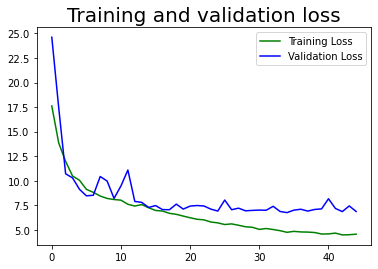

In [ ]:
# הצגת נתוני אימון בגרפים
plt.figure()
plt.plot(loss, 'g', label='Training Loss')
plt.plot(val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss', fontsize=20)
plt.legend();

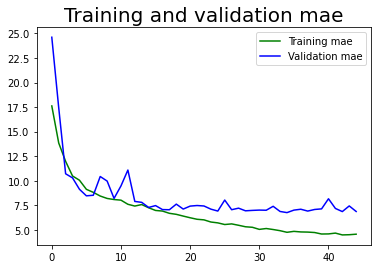

In [ ]:
plt.plot(mae, 'g', label='Training mae')
plt.plot(val_mae, 'b', label='Validation mae')
plt.title('Training and validation mae', fontsize=20)
plt.legend();

In [ ]:
# test-חיזוי נתונים מ
pred_age = model4_age.predict(ds_test_age)

75/75 [==============================] - 7s 92ms/step


In [ ]:
# הערכת ביצועים
sklearn.metrics.r2_score(test_labels_age, pred_age)

0.7721964952318634

In [ ]:
image_8 = extract_feature(df['image'][8])

Original Age: 23
1/1 [==============================] - 0s 366ms/step
Predicted Age: [[24.]]


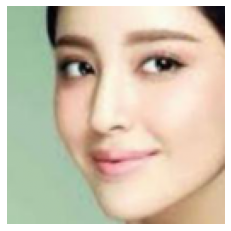

In [ ]:
# הצגה ויזואלית של פרדיקציות
print("Original Age:", df['age'][8])
predage_8 = np.round(model4_age.predict(image_8.reshape(1, 128, 128, 3)))
print("Predicted Age:", predage_8)
plt.axis('off')
plt.imshow(image_8);

### חיזוי מגדר

In [ ]:
# הכנת המודל לאימון
base_learning_rate = 0.001
model4_gender.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss={'gender':'binary_crossentropy'}, 
              metrics={'gender':'accuracy'}) 

In [ ]:
# אימון המודל
history4_gender = model4_gender.fit(train_gender,
                     epochs=70,
                     validation_data=val_gender, 
                     callbacks=[my_callback_es]) 


val_acc_list = history4_gender.history['val_accuracy']
min_val_acc = max(val_acc_list)
argmax_val_acc = np.argmax(val_acc_list)
print(f"The maximum val_accuracy was {format(min_val_acc, '.2f')} and it was reached on epoch {argmax_val_acc+1} out of {len(val_acc_list)}")

val_loss_list = history4_gender.history['val_loss']
min_val_loss = min(val_loss_list)
argmax_val_loss = np.argmax(val_loss_list)
print(f"The minimum val_loss was {format(min_val_loss, '.2f')} and it was reached on epoch {argmax_val_loss+1} out of {len(val_loss_list)}")

Epoch 1/70
238/238 [==============================] - 53s 209ms/step - loss: 0.4234 - accuracy: 0.7976 - val_loss: 0.3524 - val_accuracy: 0.8360
Epoch 2/70
238/238 [==============================] - 48s 200ms/step - loss: 0.2987 - accuracy: 0.8665 - val_loss: 0.3222 - val_accuracy: 0.8555
Epoch 3/70
238/238 [==============================] - 54s 225ms/step - loss: 0.2377 - accuracy: 0.8937 - val_loss: 0.3198 - val_accuracy: 0.8526
Epoch 4/70
238/238 [==============================] - 49s 205ms/step - loss: 0.2084 - accuracy: 0.9080 - val_loss: 0.3294 - val_accuracy: 0.8658
Epoch 5/70
238/238 [==============================] - 48s 202ms/step - loss: 0.1681 - accuracy: 0.9268 - val_loss: 0.5180 - val_accuracy: 0.8286
Epoch 6/70
238/238 [==============================] - 48s 203ms/step - loss: 0.1539 - accuracy: 0.9321 - val_loss: 0.3818 - val_accuracy: 0.8661
Epoch 7/70
238/238 [==============================] - 49s 207ms/step - loss: 0.1379 - accuracy: 0.9417 - val_loss: 0.3665 - val_ac

In [ ]:
# שמירת המודל
model4_gender.save("/content/drive/MyDrive/Colab Notebooks/Data/models/model4_gender")

In [ ]:
# שמירת נתוני אימון
acc = history4_gender.history['accuracy']
val_acc = history4_gender.history['val_accuracy']
loss = history4_gender.history['loss']
val_loss = history4_gender.history['val_loss']

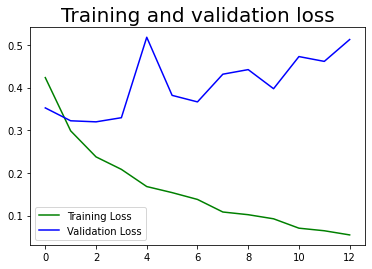

In [ ]:
# הצגת נתוני אימון בגרפים
plt.figure()
plt.plot(loss, 'g', label='Training Loss')
plt.plot(val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss', fontsize=20)
plt.legend();

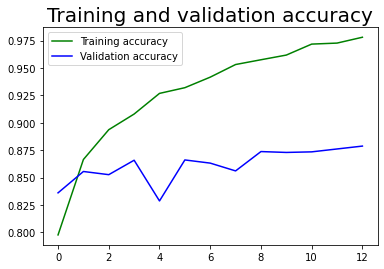

In [ ]:
plt.plot(acc, 'g', label='Training accuracy')
plt.plot(val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy', fontsize=20)
plt.legend();

In [ ]:
# test-חיזוי נתונים מ
pred_gender = predict_gender(model4_gender.predict(ds_test_gender))

75/75 [==============================] - 6s 81ms/step


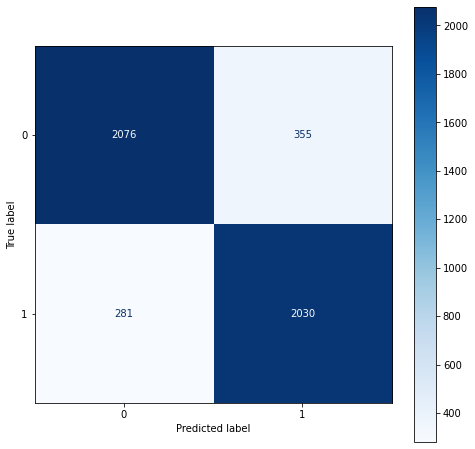

In [ ]:
# הערכת ביצועים
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(y_true=test_labels_gender, y_pred=pred_gender,cmap=plt.cm.Blues, ax=ax);

In [ ]:
print(classification_report(y_true=test_labels_gender,y_pred=pred_gender,digits=4))

              precision    recall  f1-score   support

           0     0.8808    0.8540    0.8672      2431
           1     0.8512    0.8784    0.8646      2311

    accuracy                         0.8659      4742
   macro avg     0.8660    0.8662    0.8659      4742
weighted avg     0.8663    0.8659    0.8659      4742



In [ ]:
image_8 = extract_feature(df['image'][8])

Original Gender: Female
1/1 [==============================] - 0s 119ms/step
Predicted Gender: Female


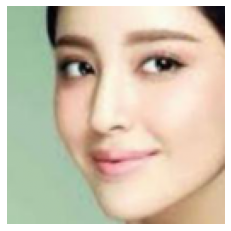

In [ ]:
# הצגה ויזואלית של פרדיקציות
print("Original Gender:", gender_dict[df['gender'][8]])
predgender_8 = predict_gender(model4_gender.predict(image_8.reshape(1, 128, 128, 3)))
print("Predicted Gender:", gender_dict[predgender_8[0][0]])
plt.axis('off')
plt.imshow(image_8);

## מודל 5

In [ ]:
# בניית מודל
inputs = tf.keras.Input(shape=(128, 128, 3))

x5 = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(inputs)
x5 = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x5)
x5 = layers.BatchNormalization()(x5)
x5 = layers.MaxPooling2D(pool_size=(3, 3))(x5)
x5 = layers.Conv2D(128, kernel_size=(3, 3), activation='relu')(x5)
x5 = layers.Conv2D(128, kernel_size=(3, 3), activation='relu')(x5)
x5 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x5)
x5 = layers.Conv2D(256, kernel_size=(3, 3), activation='relu')(x5)
x5 = layers.Conv2D(256, kernel_size=(3, 3), activation='relu')(x5)
x5 = layers.MaxPooling2D(pool_size=(2, 2))(x5)

x5 = layers.GlobalAveragePooling2D()(x5)

x5 = layers.Dense(128, activation='relu')(x5)
dense1 = layers.Dense(128, activation='relu')(x5)
dense2 = layers.Dense(128, activation='relu')(x5)
dropout1 = layers.Dropout(0.4)(dense1)
dropout2 = layers.Dropout(0.4)(dense2)

output1 = layers.Dense(1, activation='sigmoid', name='gender')(dropout1)
output2 = layers.Dense(1, activation='relu', name='age')(dropout2)

model5_age = tf.keras.Model(inputs=[inputs], outputs=[output2]) 

model5_age.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 64)      36928     
                                                                 
 batch_normalization (BatchN  (None, 124, 124, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 41, 41, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 39, 39, 128)       73856 

In [ ]:
model5_gender = tf.keras.Model(inputs=[inputs], outputs=[output1]) 
model5_gender.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 64)      36928     
                                                                 
 batch_normalization (BatchN  (None, 124, 124, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 41, 41, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 39, 39, 128)       7385

In [ ]:
# קריאה שעוצרת את תהליך האימון ברגע שאין שיפור בלמידה
my_callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

### חיזוי גיל

In [ ]:
# הנכת המודל לאימון
base_learning_rate = 0.01
model5_age.compile(optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=base_learning_rate, momentum=0.5),
              loss={'age':'mae'},    
              metrics={'age':'mae'})

In [ ]:
# אימון המודל
history5_age = model5_age.fit(train_age,
                     epochs=70,
                     validation_data=val_age, 
                     callbacks=[my_callback_es]) 


val_mae_list = history5_age.history['val_mae']
min_val_mae = min(val_mae_list)
argmax_val_mae = np.argmax(val_mae_list)
print(f"The minimum val_mae was {format(min_val_mae, '.2f')} and it was reached on epoch {argmax_val_mae+1} out of {len(val_mae_list)}")

val_loss_list = history5_age.history['val_loss']
min_val_loss = min(val_loss_list)
argmax_val_loss = np.argmax(val_loss_list)
print(f"The minimum val_loss was {format(min_val_loss, '.2f')} and it was reached on epoch {argmax_val_loss+1} out of {len(val_loss_list)}")

Epoch 1/70
238/238 [==============================] - 47s 145ms/step - loss: 25.8444 - mae: 25.8444 - val_loss: 14.9846 - val_mae: 14.9846
Epoch 2/70
238/238 [==============================] - 34s 142ms/step - loss: 15.1253 - mae: 15.1253 - val_loss: 14.4721 - val_mae: 14.4721
Epoch 3/70
238/238 [==============================] - 34s 144ms/step - loss: 14.7363 - mae: 14.7363 - val_loss: 15.0615 - val_mae: 15.0615
Epoch 4/70
238/238 [==============================] - 34s 144ms/step - loss: 14.4213 - mae: 14.4213 - val_loss: 16.8085 - val_mae: 16.8085
Epoch 5/70
238/238 [==============================] - 35s 146ms/step - loss: 13.8653 - mae: 13.8653 - val_loss: 13.4091 - val_mae: 13.4091
Epoch 6/70
238/238 [==============================] - 34s 143ms/step - loss: 12.6034 - mae: 12.6034 - val_loss: 12.4581 - val_mae: 12.4581
Epoch 7/70
238/238 [==============================] - 35s 149ms/step - loss: 11.6868 - mae: 11.6868 - val_loss: 12.3340 - val_mae: 12.3340
Epoch 8/70
238/238 [=======

In [ ]:
# שמירת המודל
model5_age.save("/content/drive/MyDrive/Colab Notebooks/Data/models/model5_age")

In [ ]:
# שמירת נתוני אימון
mae = history5_age.history['mae']
val_mae = history5_age.history['val_mae']
loss = history5_age.history['loss']
val_loss = history5_age.history['val_loss']

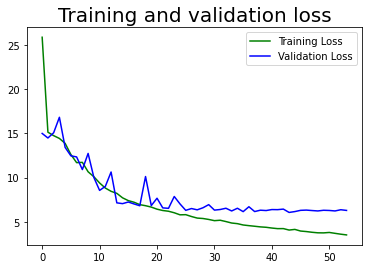

In [ ]:
# הצגת נתוני אימון בגרפים
plt.figure()
plt.plot(loss, 'g', label='Training Loss')
plt.plot(val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss', fontsize=20)
plt.legend();

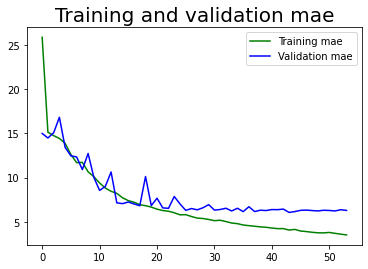

In [ ]:
plt.plot(mae, 'g', label='Training mae')
plt.plot(val_mae, 'b', label='Validation mae')
plt.title('Training and validation mae', fontsize=20)
plt.legend();

In [ ]:
# test-חיזוי נתונים מ
pred_age = model5_age.predict(ds_test_age)

75/75 [==============================] - 8s 104ms/step


In [ ]:
# הערכת ביצועים
sklearn.metrics.r2_score(test_labels_age, pred_age)

0.8014909723073116

In [ ]:
image_55 = extract_feature(df['image'][55])

Original Age: 28
1/1 [==============================] - 0s 275ms/step
Predicted Age: [[32.]]


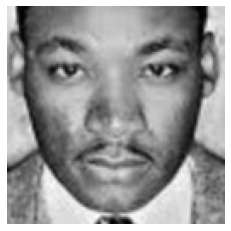

In [ ]:
# הצגה ויזואלית של פרדיקציות
print("Original Age:", df['age'][55])
predage_55 = np.round(model5_age.predict(image_55.reshape(1, 128, 128, 3)))
print("Predicted Age:", predage_55)
plt.axis('off')
plt.imshow(image_55);

### חיזוי מגדר

In [ ]:
# הכנת המודל לאימון
base_learning_rate = 0.01
model5_age.compile(optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=base_learning_rate, momentum=0.5),
              loss={'gender':'binary_crossentropy'},    
              metrics={'gender':'accuracy'})

In [ ]:
# אימון המודל
history5_gender = model5_gender.fit(train_gender,
                     epochs=70,
                     validation_data=val_gender, 
                     callbacks=[my_callback_es]) 


val_acc_list = history5_gender.history['val_accuracy']
min_val_acc = max(val_acc_list)
argmax_val_acc = np.argmax(val_acc_list)
print(f"The maximum val_accuracy was {format(min_val_acc, '.2f')} and it was reached on epoch {argmax_val_acc+1} out of {len(val_acc_list)}")

val_loss_list = history5_gender.history['val_loss']
min_val_loss = min(val_loss_list)
argmax_val_loss = np.argmax(val_loss_list)
print(f"The minimum val_loss was {format(min_val_loss, '.2f')} and it was reached on epoch {argmax_val_loss+1} out of {len(val_loss_list)}")

Epoch 1/70
238/238 [==============================] - 36s 149ms/step - loss: 0.4187 - accuracy: 0.8129 - val_loss: 0.4011 - val_accuracy: 0.8286
Epoch 2/70
238/238 [==============================] - 34s 142ms/step - loss: 0.6161 - accuracy: 0.6796 - val_loss: 0.6937 - val_accuracy: 0.5157
Epoch 3/70
238/238 [==============================] - 34s 143ms/step - loss: 0.6932 - accuracy: 0.5065 - val_loss: 0.6932 - val_accuracy: 0.5157
Epoch 4/70
238/238 [==============================] - 34s 143ms/step - loss: 0.6929 - accuracy: 0.5178 - val_loss: 0.6935 - val_accuracy: 0.5157
Epoch 5/70
238/238 [==============================] - 34s 143ms/step - loss: 0.6928 - accuracy: 0.5199 - val_loss: 0.6927 - val_accuracy: 0.5157
Epoch 6/70
238/238 [==============================] - 34s 141ms/step - loss: 0.6925 - accuracy: 0.5211 - val_loss: 0.6927 - val_accuracy: 0.5157
Epoch 7/70
238/238 [==============================] - 34s 144ms/step - loss: 0.6927 - accuracy: 0.5211 - val_loss: 0.6927 - val_ac

In [ ]:
# שמירת המודל
model5_gender.save("/content/drive/MyDrive/Colab Notebooks/Data/models/model5_gender")

In [ ]:
# שמירת נתוני אימון
acc = history5_gender.history['accuracy']
val_acc = history5_gender.history['val_accuracy']
loss = history5_gender.history['loss']
val_loss = history5_gender.history['val_loss']

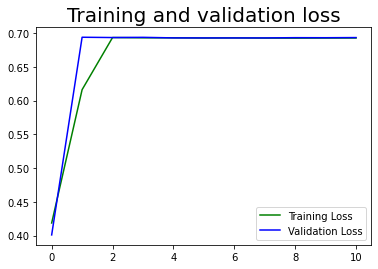

In [ ]:
# הצגת נתוני אימון בגרפים
plt.figure()
plt.plot(loss, 'g', label='Training Loss')
plt.plot(val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss', fontsize=20)
plt.legend();

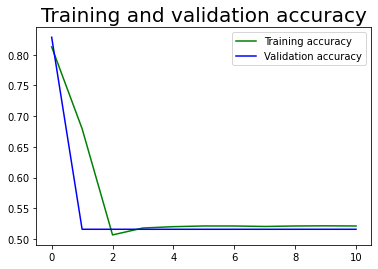

In [ ]:
plt.plot(acc, 'g', label='Training accuracy')
plt.plot(val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy', fontsize=20)
plt.legend();

In [ ]:
# test-חיזוי נתונים מ
pred_gender = predict_gender(model5_gender.predict(ds_test_gender))

75/75 [==============================] - 6s 79ms/step


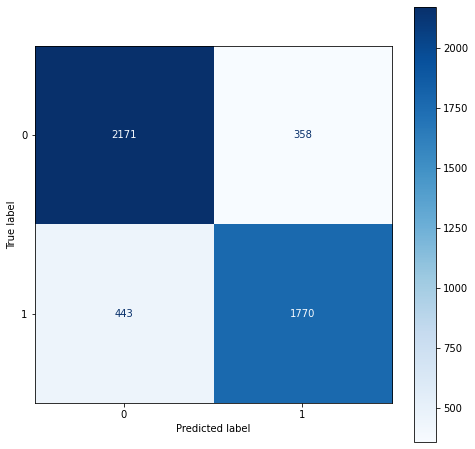

In [ ]:
# הערכת ביצועים
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(y_true=test_labels_gender, y_pred=pred_gender,cmap=plt.cm.Blues, ax=ax);

In [ ]:
print(classification_report(y_true=test_labels_gender,y_pred=pred_gender,digits=4))

              precision    recall  f1-score   support

           0     0.8305    0.8584    0.8443      2529
           1     0.8318    0.7998    0.8155      2213

    accuracy                         0.8311      4742
   macro avg     0.8311    0.8291    0.8299      4742
weighted avg     0.8311    0.8311    0.8308      4742



In [ ]:
image_55 = extract_feature(df['image'][55])

Original Gender: Male
1/1 [==============================] - 0s 104ms/step
Predicted Gender: Male


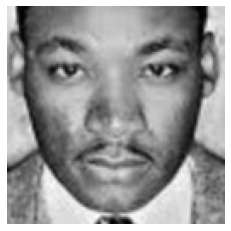

In [ ]:
# הצגה ויזואלית של פרדיקציות
print("Original Gender:", gender_dict[df['gender'][55]])
predgender_55 = predict_gender(model5_gender.predict(image_55.reshape(1, 128, 128, 3)))
print("Predicted Gender:", gender_dict[predgender_55[0][0]])
plt.axis('off')
plt.imshow(image_55);

## Transfer learning - age

In [ ]:
# שינוי נתונים קיימים ע"י סיבוב וכדומה
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
# עיבוד מקדים של נתונים
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
# הגדרת מודל בסיסי
IMG_SIZE = (128, 128)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
# הפיכת המודל ללא ניתן לאימון
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

In [ ]:
# global average pooling הוספת שכבת 
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [ ]:
# בניית המודל
x = base_model.layers[-1].output
x = data_augmentation(x)
x = preprocess_input(x)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.5)(x)

dense_gender1 = tf.keras.layers.Dense(256, activation='relu')(x)
dropout_gender1 = tf.keras.layers.Dropout(0.3)(dense_gender1)

dense_age1 = tf.keras.layers.Dense(256, activation='relu')(x)
dropout_age1 = tf.keras.layers.Dropout(0.3)(dense_age1)

predictions_gender = Dense(1, activation='sigmoid', name='gender')(dropout_gender1)
predictions_age = Dense(1, activation='relu', name='age')(dropout_age1)

modeltl_age = tf.keras.Model(inputs=base_model.input, outputs=[predictions_age]) 

In [ ]:
# הכנת המודל לאימון
base_learning_rate = 0.001
modeltl_age.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss={'age':'mae'},    
              metrics={'age':'mae'}) 

In [ ]:
modeltl_age.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']         

In [ ]:
# אימון המודל
initial_epochs = 30

historytl_age = modeltl_age.fit(train_age,
                    epochs=initial_epochs,
                    validation_data=val_age)

Epoch 1/30


238/238 [==============================] - 106s 370ms/step - loss: 15.5130 - mae: 15.5130 - val_loss: 15.3500 - val_mae: 15.3500
Epoch 2/30
238/238 [==============================] - 80s 337ms/step - loss: 15.3354 - mae: 15.3354 - val_loss: 15.1401 - val_mae: 15.1401
Epoch 3/30
238/238 [==============================] - 75s 317ms/step - loss: 15.3205 - mae: 15.3205 - val_loss: 14.9931 - val_mae: 14.9931
Epoch 4/30
238/238 [==============================] - 69s 288ms/step - loss: 15.2897 - mae: 15.2897 - val_loss: 14.9967 - val_mae: 14.9967
Epoch 5/30
238/238 [==============================] - 68s 286ms/step - loss: 15.2924 - mae: 15.2924 - val_loss: 14.9951 - val_mae: 14.9951
Epoch 6/30
238/238 [==============================] - 68s 288ms/step - loss: 15.2584 - mae: 15.2584 - val_loss: 15.0164 - val_mae: 15.0164
Epoch 7/30
238/238 [==============================] - 68s 285ms/step - loss: 15.2604 - mae: 15.2604 - val_loss: 14.9934 - val_mae: 14.9934
Epoch 8/30
238/238 [=================

In [ ]:
# שמירת המודל
modeltl_age.save("/content/drive/MyDrive/Colab Notebooks/Data/models/modeltl_age")

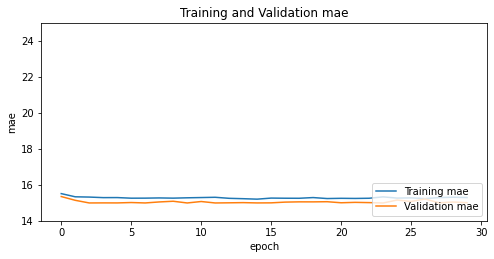

In [ ]:
# הצגת נתוני אימון בגרף
mae = historytl_age.history['mae']
val_mae = historytl_age.history['val_mae']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(mae, label='Training mae')
plt.plot(val_mae, label='Validation mae')
plt.legend(loc='lower right')
plt.ylabel('mae')
plt.ylim(14, 25)
plt.title('Training and Validation mae')

plt.xlabel('epoch')
plt.show()

In [ ]:
image_78 = extract_feature(df['image'][78])

Original Age: 30
1/1 [==============================] - 1s 1s/step
Predicted Age: [[30.]]


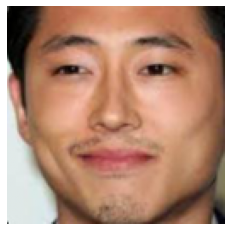

In [ ]:
# הצגה ויזואלית של פרדיקציות
print("Original Age:", df['age'][78])
predage_78 = np.round(modeltl_age.predict(image_78.reshape(1, 128, 128, 3)))
print("Predicted Age:", predage_78)
plt.axis('off')
plt.imshow(image_78);

### Fine tuning

In [ ]:
# הפיכת המודל לניתן לאימון 
base_model.trainable = True

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [ ]:
# הפיכת מספר שכבות ללא ניתנות לאימון
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
# הכנת המודל לאימון
modeltl_age.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss={'age':'mae'},    
              metrics={'age':'mae'}) 

In [ ]:
modeltl_age.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']         

In [ ]:
# אימון המודל
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

history_fine_age = modeltl_age.fit(train_age,
                         epochs=total_epochs,
                         initial_epoch=historytl_age.epoch[-1],
                         validation_data=val_age)

Epoch 30/60


238/238 [==============================] - 118s 427ms/step - loss: 15.0477 - mae: 15.0477 - val_loss: 14.6588 - val_mae: 14.6588
Epoch 31/60
238/238 [==============================] - 94s 396ms/step - loss: 14.9556 - mae: 14.9556 - val_loss: 14.6597 - val_mae: 14.6597
Epoch 32/60
238/238 [==============================] - 93s 392ms/step - loss: 14.9566 - mae: 14.9566 - val_loss: 14.6953 - val_mae: 14.6953
Epoch 33/60
238/238 [==============================] - 94s 395ms/step - loss: 14.9296 - mae: 14.9296 - val_loss: 14.6569 - val_mae: 14.6569
Epoch 34/60
238/238 [==============================] - 93s 389ms/step - loss: 14.9469 - mae: 14.9469 - val_loss: 14.7832 - val_mae: 14.7832
Epoch 35/60
238/238 [==============================] - 93s 389ms/step - loss: 14.9125 - mae: 14.9125 - val_loss: 14.6950 - val_mae: 14.6950
Epoch 36/60
238/238 [==============================] - 94s 394ms/step - loss: 14.8886 - mae: 14.8886 - val_loss: 14.7425 - val_mae: 14.7425
Epoch 37/60
238/238 [==========

In [ ]:
# שמירת המודל
modeltl_age.save("/content/drive/MyDrive/Colab Notebooks/Data/models/modeltl_age_ft")

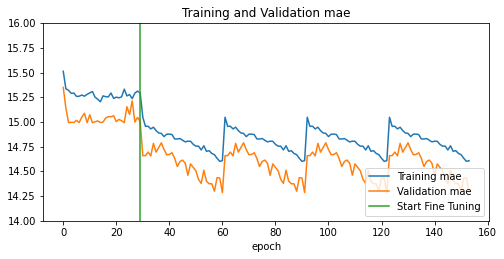

In [ ]:
# הצגת נתוני אימון בגרף
mae += history_fine_age.history['mae']
val_mae += history_fine_age.history['val_mae']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(mae, label='Training mae')
plt.plot(val_mae, label='Validation mae')
plt.ylim([14, 16])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation mae')
plt.xlabel('epoch')
plt.show()

In [ ]:
# test-חיזוי נתונים מ
pred_age = modeltl_age.predict(ds_test_age)

75/75 [==============================] - 8s 97ms/step


In [ ]:
# הערכת ביצועים
sklearn.metrics.r2_score(test_labels_age, pred_age)

0.03446136683214285

In [ ]:
image_57 = extract_feature(df['image'][57])

Original Age: 65
1/1 [==============================] - 1s 769ms/step
Predicted Age: [[30.]]


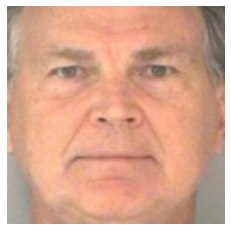

In [ ]:
# הצגה ויזואלית של פרדיקציות
print("Original Age:", df['age'][57])
predage_57 = np.round(modeltl_age.predict(image_57.reshape(1, 128, 128, 3)))
print("Predicted Age:", predage_57)
plt.axis('off')
plt.imshow(image_57);

## Transfer learning - gender 

In [ ]:
# שינוי נתונים קיימים ע"י סיבוב וכדומה
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
# עיבוד מקדים של נתונים
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
# הגדרת מודל בסיסי
IMG_SIZE = (128, 128)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# הפיכת המודל ללא ניתן לאימון
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

In [ ]:
# global average pooling הוספת שכבת
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [ ]:
# בניית המודל
x = base_model.layers[-1].output
x = data_augmentation(x)
x = preprocess_input(x)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.5)(x)

dense_gender1 = tf.keras.layers.Dense(256, activation='relu')(x)
dropout_gender1 = tf.keras.layers.Dropout(0.3)(dense_gender1)

dense_age1 = tf.keras.layers.Dense(256, activation='relu')(x)
dropout_age1 = tf.keras.layers.Dropout(0.3)(dense_age1)

predictions_gender = Dense(1, activation='sigmoid', name='gender')(dropout_gender1)
predictions_age = Dense(1, activation='relu', name='age')(dropout_age1)

modeltl_gender = tf.keras.Model(inputs=base_model.input, outputs=[predictions_gender]) 

In [ ]:
# הכנת המודל לאימון
base_learning_rate = 0.001
modeltl_gender.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss={'gender':'binary_crossentropy'}, 
              metrics={'gender':'accuracy'}) 

In [ ]:
modeltl_gender.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']           

In [ ]:
# אימון המודל
initial_epochs = 30

historytl_gender = modeltl_gender.fit(train_gender,
                    epochs=initial_epochs,
                    validation_data=val_gender)

Epoch 1/30
238/238 [==============================] - 89s 376ms/step - loss: 0.6944 - accuracy: 0.5110 - val_loss: 0.6934 - val_accuracy: 0.4714
Epoch 2/30
238/238 [==============================] - 80s 338ms/step - loss: 0.6932 - accuracy: 0.5136 - val_loss: 0.6916 - val_accuracy: 0.5286
Epoch 3/30
238/238 [==============================] - 73s 308ms/step - loss: 0.6927 - accuracy: 0.5207 - val_loss: 0.6922 - val_accuracy: 0.5286
Epoch 4/30
238/238 [==============================] - 74s 311ms/step - loss: 0.6926 - accuracy: 0.5201 - val_loss: 0.6919 - val_accuracy: 0.5286
Epoch 5/30
238/238 [==============================] - 73s 308ms/step - loss: 0.6925 - accuracy: 0.5211 - val_loss: 0.6917 - val_accuracy: 0.5286
Epoch 6/30
238/238 [==============================] - 74s 310ms/step - loss: 0.6924 - accuracy: 0.5209 - val_loss: 0.6916 - val_accuracy: 0.5286
Epoch 7/30
238/238 [==============================] - 73s 306ms/step - loss: 0.6924 - accuracy: 0.5207 - val_loss: 0.6916 - val_ac

In [ ]:
# שמירת המודל
modeltl_gender.save("/content/drive/MyDrive/Colab Notebooks/Data/models/modeltl_gender")

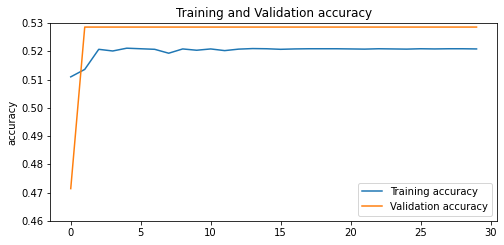

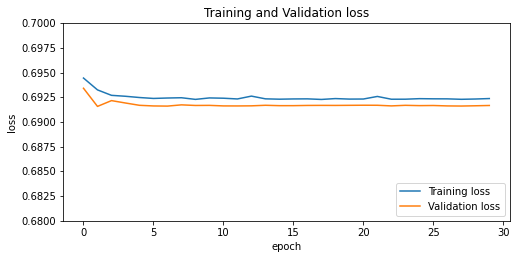

In [ ]:
# הצגת נתוני אימון בגרפים
acc = historytl_gender.history['accuracy']
val_acc = historytl_gender.history['val_accuracy']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.ylabel('accuracy')
plt.ylim(0.46, 0.53)
plt.title('Training and Validation accuracy')

loss = historytl_gender.history['loss']
val_loss = historytl_gender.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend(loc='lower right')
plt.ylabel('loss')
plt.ylim(0.68, 0.7)
plt.title('Training and Validation loss')

plt.xlabel('epoch')
plt.show()

In [ ]:
# test-חיזוי נתונים מ
pred_gender = predict_gender(modeltl_gender.predict(ds_test_gender))

75/75 [==============================] - 8s 86ms/step


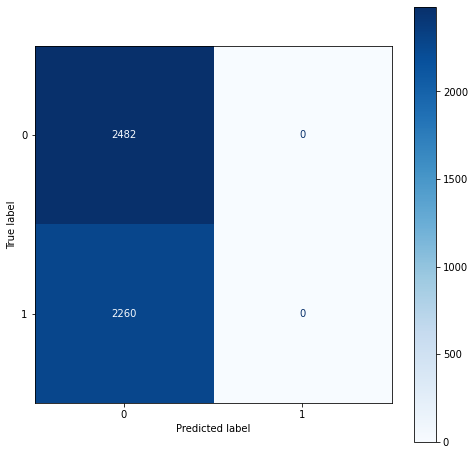

In [ ]:
# הערכת ביצועים
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(y_true=test_labels_gender, y_pred=pred_gender,cmap=plt.cm.Blues, ax=ax);

In [ ]:
print(classification_report(y_true=test_labels_gender,y_pred=pred_gender,digits=4))

              precision    recall  f1-score   support

           0     0.5234    1.0000    0.6872      2482
           1     0.0000    0.0000    0.0000      2260

    accuracy                         0.5234      4742
   macro avg     0.2617    0.5000    0.3436      4742
weighted avg     0.2740    0.5234    0.3597      4742



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
image_64 = extract_feature(df['image'][64])

Original Gender: Male
1/1 [==============================] - 1s 1s/step
Predicted Gender: Male


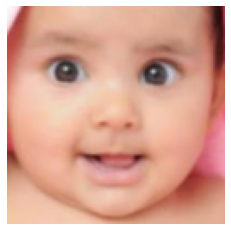

In [ ]:
# הצגה ויזואלית של פרדיקציות
print("Original Gender:", gender_dict[df['gender'][64]])
predgender_64 = predict_gender(modeltl_gender.predict(image_64.reshape(1, 128, 128, 3)))
print("Predicted Gender:", gender_dict[predgender_64[0][0]])
plt.axis('off')
plt.imshow(image_64);

### Fine tuning 

In [ ]:
# הפיכת המודל לניתן לאימון
base_model.trainable = True

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [ ]:
# הפיכת מספר שכבות ללא ניתנות לאימון 
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
# הכנת המודל לאימון
modeltl_gender.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss={'gender':'binary_crossentropy'}, 
              metrics={'gender':'accuracy'}) 

In [ ]:
modeltl_gender.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']           

In [ ]:
# אימון המודל
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

history_fine_gender = modeltl_gender.fit(train_gender,
                         epochs=total_epochs,
                         initial_epoch=historytl_gender.epoch[-1],
                         validation_data=val_gender)

Epoch 30/60


238/238 [==============================] - 122s 437ms/step - loss: 0.6923 - accuracy: 0.5209 - val_loss: 0.6917 - val_accuracy: 0.5286
Epoch 31/60
238/238 [==============================] - 99s 416ms/step - loss: 0.6923 - accuracy: 0.5209 - val_loss: 0.6917 - val_accuracy: 0.5286
Epoch 32/60
238/238 [==============================] - 100s 419ms/step - loss: 0.6923 - accuracy: 0.5209 - val_loss: 0.6917 - val_accuracy: 0.5286
Epoch 33/60
238/238 [==============================] - 97s 409ms/step - loss: 0.6923 - accuracy: 0.5209 - val_loss: 0.6917 - val_accuracy: 0.5286
Epoch 34/60
238/238 [==============================] - 98s 411ms/step - loss: 0.6923 - accuracy: 0.5209 - val_loss: 0.6916 - val_accuracy: 0.5286
Epoch 35/60
238/238 [==============================] - 99s 417ms/step - loss: 0.6923 - accuracy: 0.5209 - val_loss: 0.6916 - val_accuracy: 0.5286
Epoch 36/60
238/238 [==============================] - 98s 412ms/step - loss: 0.6923 - accuracy: 0.5209 - val_loss: 0.6916 - val_accur

In [ ]:
# שמירת המודל
modeltl_gender.save("/content/drive/MyDrive/Colab Notebooks/Data/models/modeltl_gender_ft")

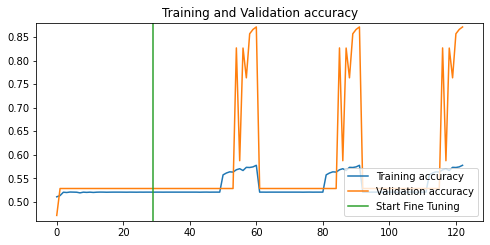

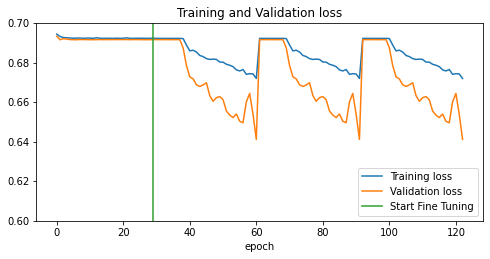

In [ ]:
# הצגת נתוני אימון בגרפים
acc += history_fine_gender.history['accuracy']
val_acc += history_fine_gender.history['val_accuracy']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.ylim([0.46, 0.88])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation accuracy')

loss += history_fine_gender.history['loss']
val_loss += history_fine_gender.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.ylim([0.6, 0.7])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation loss')

plt.xlabel('epoch')
plt.show()

In [ ]:
# test-חיזוי נתונים מ
pred_gender = predict_gender(modeltl_gender.predict(ds_test_gender))

75/75 [==============================] - 7s 83ms/step


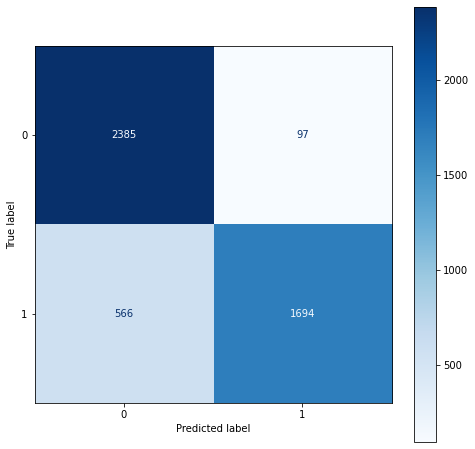

In [ ]:
# הערכת ביצועים
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(y_true=test_labels_gender, y_pred=pred_gender,cmap=plt.cm.Blues, ax=ax);

In [ ]:
print(classification_report(y_true=test_labels_gender,y_pred=pred_gender,digits=4))

              precision    recall  f1-score   support

           0     0.8082    0.9609    0.8780      2482
           1     0.9458    0.7496    0.8363      2260

    accuracy                         0.8602      4742
   macro avg     0.8770    0.8552    0.8572      4742
weighted avg     0.8738    0.8602    0.8581      4742



In [ ]:
image_88 = extract_feature(df['image'][88])

Original Gender: Female
1/1 [==============================] - 1s 1s/step
Predicted Gender: Female


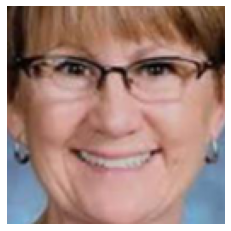

In [ ]:
# הצגה ויזואלית של פרדיקציות
print("Original Gender:", gender_dict[df['gender'][88]])
predgender_88 = predict_gender(modeltl_gender.predict(image_88.reshape(1, 128, 128, 3)))
print("Predicted Gender:", gender_dict[predgender_88[0][0]])
plt.axis('off')
plt.imshow(image_88);

## anvil

In [ ]:
# anvil של uplink התקנת
!pip install anvil-uplink

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 KB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ws4py: filename=ws4py-0.5.1-py3-none-any.whl size=45228 sha256=b6989f97553963f06e9faf3748347e30c1a02dc8f236edcdc88fb07e95219c6d
  Stored in directory: /root/.cache/pip/wheels/e8/9d/fd/0a594a1bc8d493935d319ac40d64d79f5b4117ef4d37b1b678
Successfully built ws4py


In [ ]:
# anvil-חיבור המחברת ל
import anvil.server
import anvil.media
import cv2
anvil.server.connect("server_6IOENBFZFU4AYTTF2GG3N5QR-XHYQPRHSSZBMUSKM")

In [ ]:
# טעינת המודלים עם הביצועים הכי טובים
model2_age_loaded = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Data/models/model5_age')
model2_gender_loaded = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Data/models/model3_gender')

In [ ]:
# פונקציה לחיזוי גיל
@anvil.server.callable
def predict_age_func(file):
  with anvil.media.TempFile(file) as f:
    img = tf.keras.utils.load_img(f)
  img_arr = np.array(img)
  img_arr=cv2.resize(img_arr, (128,128), interpolation = cv2.INTER_AREA)
  img_arr=img_arr/255
  img_arr=np.expand_dims(img_arr, axis=0)
  img_label=np.round(model2_age_loaded.predict(img_arr))
  return img_label[0][0]

In [ ]:
# פונקציה לחיזוי מגדר
@anvil.server.callable
def predict_gender_func(img):
  with anvil.media.TempFile(img) as f:
    img = tf.keras.utils.load_img(f)
  img_arr = np.array(img)
  img_arr=cv2.resize(img_arr, (128,128), interpolation = cv2.INTER_AREA)
  img_arr=img_arr/255
  img_arr=np.expand_dims(img_arr, axis=0)
  img_label=predict_gender(model2_gender_loaded.predict(img_arr))
  return gender_dict[img_label[0][0]]